#      Cerebral Stroke Prediction
### By: Shivam Chaudhary


### **Problem Statement:**

In the realm of stroke prediction, there exists a critical need to discern the key factors contributing to stroke occurrences, leveraging predictive modeling to identify individuals susceptible to cerebral strokes. Addressing the challenge of class imbalance within the "Cerebral Stroke Prediction" dataset, our objective is to construct a machine learning model capable of accurately predicting stroke incidences. With a strong emphasis on evaluating the model's performance metrics, including accuracy, sensitivity, and specificity, we seek to empower healthcare providers with actionable insights to elevate patient care standards and mitigate the prevalence of strokes.

---

### **Objective:**

The aim of this project is to leverage machine learning techniques to construct a robust predictive model for identifying individuals at a heightened risk of cerebral strokes. Focusing on the "Cerebral Stroke Prediction" dataset, characterized by class imbalance, the objective is to create a model that effectively detects stroke occurrences while comprehensively addressing the challenge posed by imbalanced data. By understanding the crucial factors contributing to stroke occurrence, we aspire to provide valuable insights for healthcare providers, enabling them to enhance patient care and minimize the risks associated with strokes.

---

### **About Data:**

The "Cerebral Stroke Prediction" dataset serves as an invaluable real-world resource for identifying potential occurrences of cerebral strokes in individuals. Primarily designed for developing predictive models, the dataset emphasizes the significance of early detection and intervention in mitigating the severity and consequences of strokes. With a focus on binary classification, the dataset's target variable indicates whether a patient has suffered a stroke (denoted as 1) or has not (denoted as 0). This dataset notably exhibits class imbalance, thereby necessitating the employment of specialized techniques to ensure the accurate prediction of stroke incidences. Leveraging this data, our goal is to unravel the complex interplay of various attributes contributing to stroke occurrences and to develop an effective model that aids healthcare providers in improving patient care and proactively reducing the risk of strokes.

In [76]:
# importing libraies 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Importing Machine Learning Model/Algorithm libraries

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,precision_score,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV
import random
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset

df = pd.read_csv("dataset.csv")
print(df.shape)
df.sample(10)

(43400, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
14373,54890,Male,8.00,0,0,No,children,Urban,125.44,17.0,NaN,0
20448,9639,Female,17.00,0,0,No,Private,Rural,90.23,23.0,never smoked,0
34132,4855,Female,45.00,0,0,Yes,Private,Rural,113.22,27.8,formerly smoked,0
5380,19618,Female,60.00,0,0,Yes,Self-employed,Urban,69.70,38.1,formerly smoked,0
9406,43517,Male,1.32,0,0,No,children,Rural,74.99,21.4,NaN,0
35191,37896,Female,49.00,1,0,Yes,Private,Rural,112.32,34.8,never smoked,0
14535,44726,Male,42.00,0,0,Yes,Self-employed,Urban,150.05,32.1,never smoked,0
38949,47526,Female,11.00,0,0,No,children,Rural,96.06,20.7,never smoked,0
5378,43959,Female,63.00,0,0,Yes,Private,Urban,91.99,24.1,never smoked,0
39657,56957,Male,43.00,0,0,Yes,Private,Rural,67.46,34.0,never smoked,0


- Dataset contains 43400 rows and 12 columns. The 'Id' column will be removed as it lacks significance for analysis and model building due to its unique values. The remaining columns will be thoroughly analyzed in subsequent steps.

###  Data Cleaning 

In [3]:
# removing id column

df = df.drop(columns=['id'])

In [4]:
# Renaming the columns

df = df.rename(columns={
    'gender': 'Gender',
    'age': 'Age',
    'hypertension': 'Hypertension',
    'heart_disease': 'Heart Disease',
    'ever_married': 'Ever Married',
    'work_type': 'Work Type',
    'Residence_type': 'Residence Type',
    'avg_glucose_level': 'Avg Glucose Level',
    'bmi': 'BMI',
    'smoking_status': 'Smoking Status',
    'stroke': 'Stroke'
})



In [5]:
# checking null values 

df.isna().sum()

Gender                   0
Age                      0
Hypertension             0
Heart Disease            0
Ever Married             0
Work Type                0
Residence Type           0
Avg Glucose Level        0
BMI                   1462
Smoking Status       13292
Stroke                   0
dtype: int64

- 'BMI' and 'Smoking Status' has 1462 and 13292 null values respectively, let's deal with them.

In [6]:
# Checking Smoking Status columns

print(df['Smoking Status'].value_counts())


never smoked       16053
formerly smoked     7493
smokes              6562
Name: Smoking Status, dtype: int64


- To handle the 13,292 null values within the three distinct categories 'never smoked', 'formerly smoked', and 'smokes', it is not advisable to remove them due to potential significant data loss. Instead, the null values can be filled with the keyword 'unknown' for effective data management.

In [7]:
# Filling null values of 'Smoking Status' with 'unknown'

df['Smoking Status'] = df['Smoking Status'].fillna('Unknown')

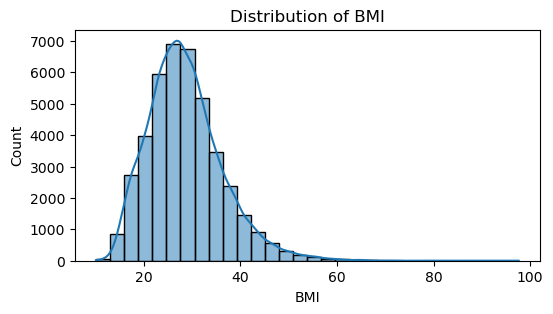

In [8]:
# Checking BMI column

plt.figure(figsize=(6, 3))
sns.histplot(data=df, x='BMI', kde=True, bins=30)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

- we can see data is reght-skeweed. To address the right-skewed data with null values in the 'BMI' column, it is advisable to fill the null values with the mean. This approach is suitable since 'BMI' is a continuous variable, and such imputation can contribute to the reduction of skewness.

In [9]:
# Filling null values of 'BMI' with mean by using SimpleImputer

from sklearn.impute import SimpleImputer
import pandas as pd

imputer = SimpleImputer(strategy='mean')  # You can also use 'median', 'most_frequent', or 'constant'

df['BMI'] = imputer.fit_transform(df[['BMI']])

In [10]:
# ckecking nul values again

df.isna().sum().sum()

0

- All the null vlues are remove.

In [11]:
# checking duplicate rows

df.duplicated().sum()

0

- No duplicate row found

In [12]:
# checking unwanted characters in dataset

special_chars = set(['/','?','#','-','_','<','>','+'])
result = df.applymap(lambda x: any(char in special_chars for char in str(x) if isinstance(x, str)))

result.sum()

Gender                   0
Age                      0
Hypertension             0
Heart Disease            0
Ever Married             0
Work Type            12410
Residence Type           0
Avg Glucose Level        0
BMI                      0
Smoking Status           0
Stroke                   0
dtype: int64

- We can see 'Work Type' has unwanted charaters let's explore this column


In [13]:
df['Work Type'].value_counts()

Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: Work Type, dtype: int64

- We observe that 'Word Type' falls into 5 categories, with 3 of these categories containing special characters. While it's unnecessary to eliminate these characters for the analysis, presenting them in a more reader-friendly format would be beneficial.

In [14]:
# rewriting class name

df['Work Type'] = df['Work Type'].str.replace('-', ' ').str.replace('_', ' ').str.title()

df['Work Type'].value_counts()

Private          24834
Self Employed     6793
Children          6156
Govt Job          5440
Never Worked       177
Name: Work Type, dtype: int64

- Now data is cleaned and we can move to next step

### EDA

In [15]:
# checking Stats of numerical columns

df.describe()

,Age,Hypertension,Heart Disease,Avg Glucose Level,BMI,Stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000
mean,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,22.519649,0.291235,0.212733,43.111751,7.638023,0.133103
min,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.000000,0.000000,77.540000,23.400000,0.000000
50%,44.000000,0.000000,0.000000,91.580000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,112.070000,32.600000,0.000000
max,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


- Age: Age ranges from 0.08 to 82.00, suggesting possible outliers near minimum value. Data appears normally distributed, although an age of 0 is improbable.
- Hypertension: Check distribution by examining category counts.
- Heart Disease: Examine category counts for distribution analysis.
- Avg Glucose Level: Note significant difference between 3rd quantile and maximum, indicating possible outliers and skewness. Visual inspection needed.
- BMI: Similar behavior as Avg Glucose Level, warranting visual examination.
- Stroke: Categorical label, to be addressed in upcoming steps.

In [16]:
# checking Stats of object columns

df.describe(include=['O'])

,Gender,Ever Married,Work Type,Residence Type,Smoking Status
count,43400,43400,43400,43400,43400
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,25665,27938,24834,21756,16053




- Gender: 3 unique values, with 'Female' as the top entry (25,665 occurrences).
- Ever Married: 2 categories, with 'Yes' being the most frequent (27,938 occurrences).
- Work Type: 5 distinct types, 'Private' being the most common (24,834 occurrences).
- Residence Type: 2 types, with 'Urban' leading (21,756 occurrences).
- Smoking Status: 4 categories, 'never smoked' being the highest (16,053 occurrences).

In [17]:
df.columns

Index(['Gender', 'Age', 'Hypertension', 'Heart Disease', 'Ever Married',
       'Work Type', 'Residence Type', 'Avg Glucose Level', 'BMI',
       'Smoking Status', 'Stroke'],
      dtype='object')

In [18]:
# seperating categorical and continous columns for visual analysis

cat = ['Gender', 'Hypertension', 'Heart Disease', 'Ever Married',
       'Work Type', 'Residence Type','Smoking Status', 'Stroke']

con = ['Age', 'Avg Glucose Level', 'BMI',]

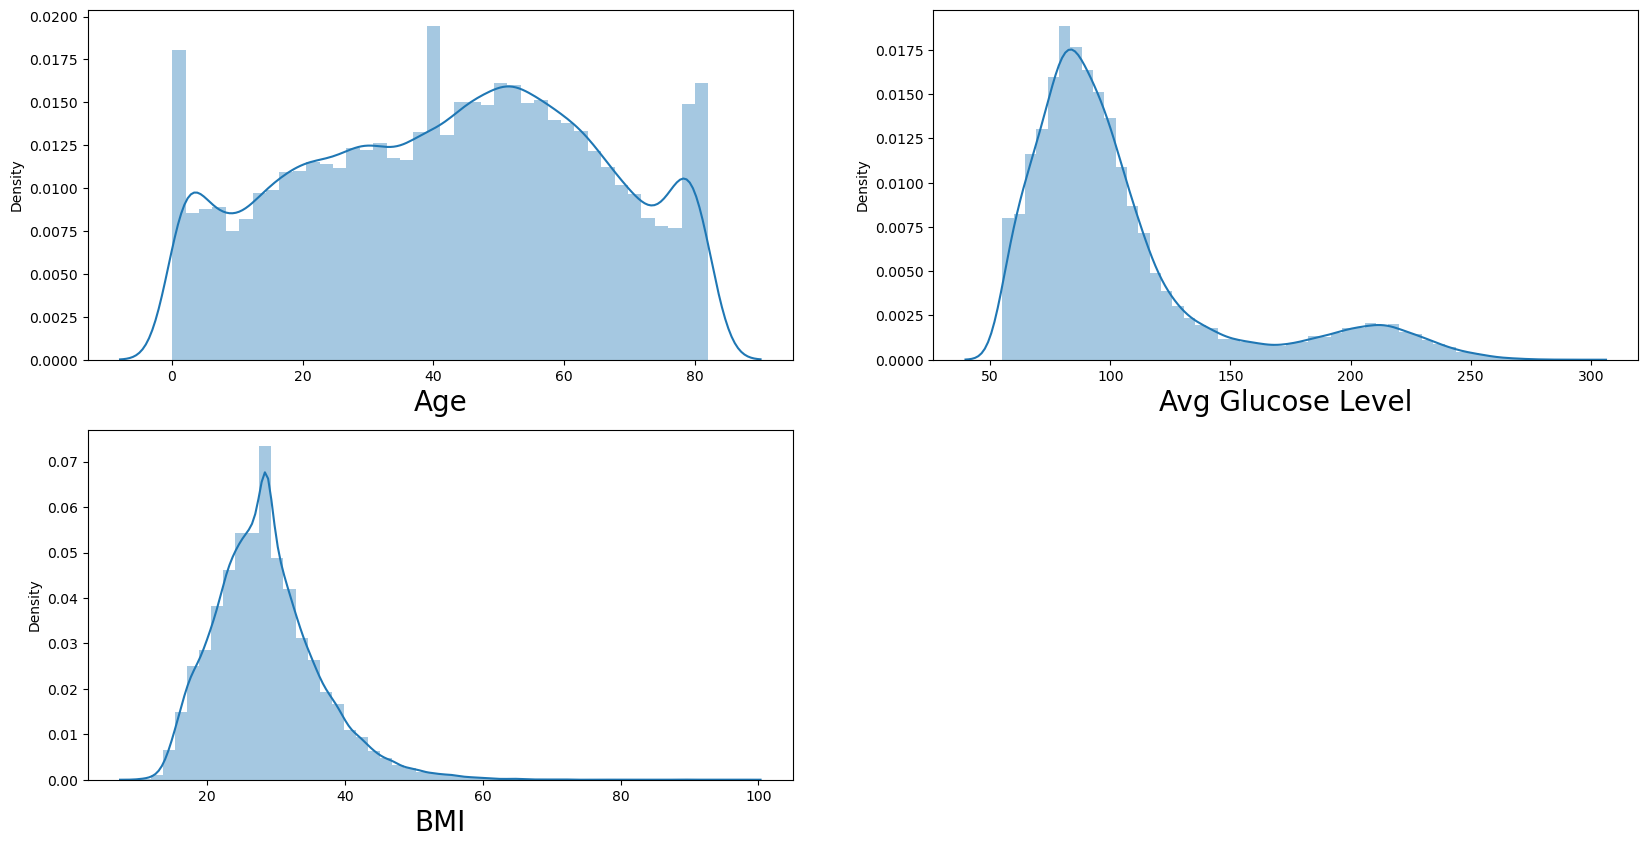

In [19]:
# checking distribution in continous column

plt.figure(figsize=(20,10))
count = 1

for i in con:
    if count<=3:
        ax = plt.subplot(2,2,count)
        sns.distplot(df[i])
        plt.xlabel(i, fontsize=20)
    count+=1
plt.show()    
        

- Age: Investigating data points indicating an age of zero, which seems erroneous as age can't be zero.
- Avg Glucose Level: Data displays a right-skewed distribution. Careful attention required as readings of 300 mg/dL or more can be potentially dangerous. Contacting a doctor is advisable if there are 2 consecutive readings of 300 or above.
- BMI: Skewed to the right, suggesting a potential imbalance in the data distribution.

In [20]:
# checking age column that how many values are 0.0

count_zeros = (df['Age'] == 0.0).sum()

print(f"Number of occurrences of 0.0 in the 'Age' column: {count_zeros}")

Number of occurrences of 0.0 in the 'Age' column: 0


- we are good to go now as age don't have any 0.0 value

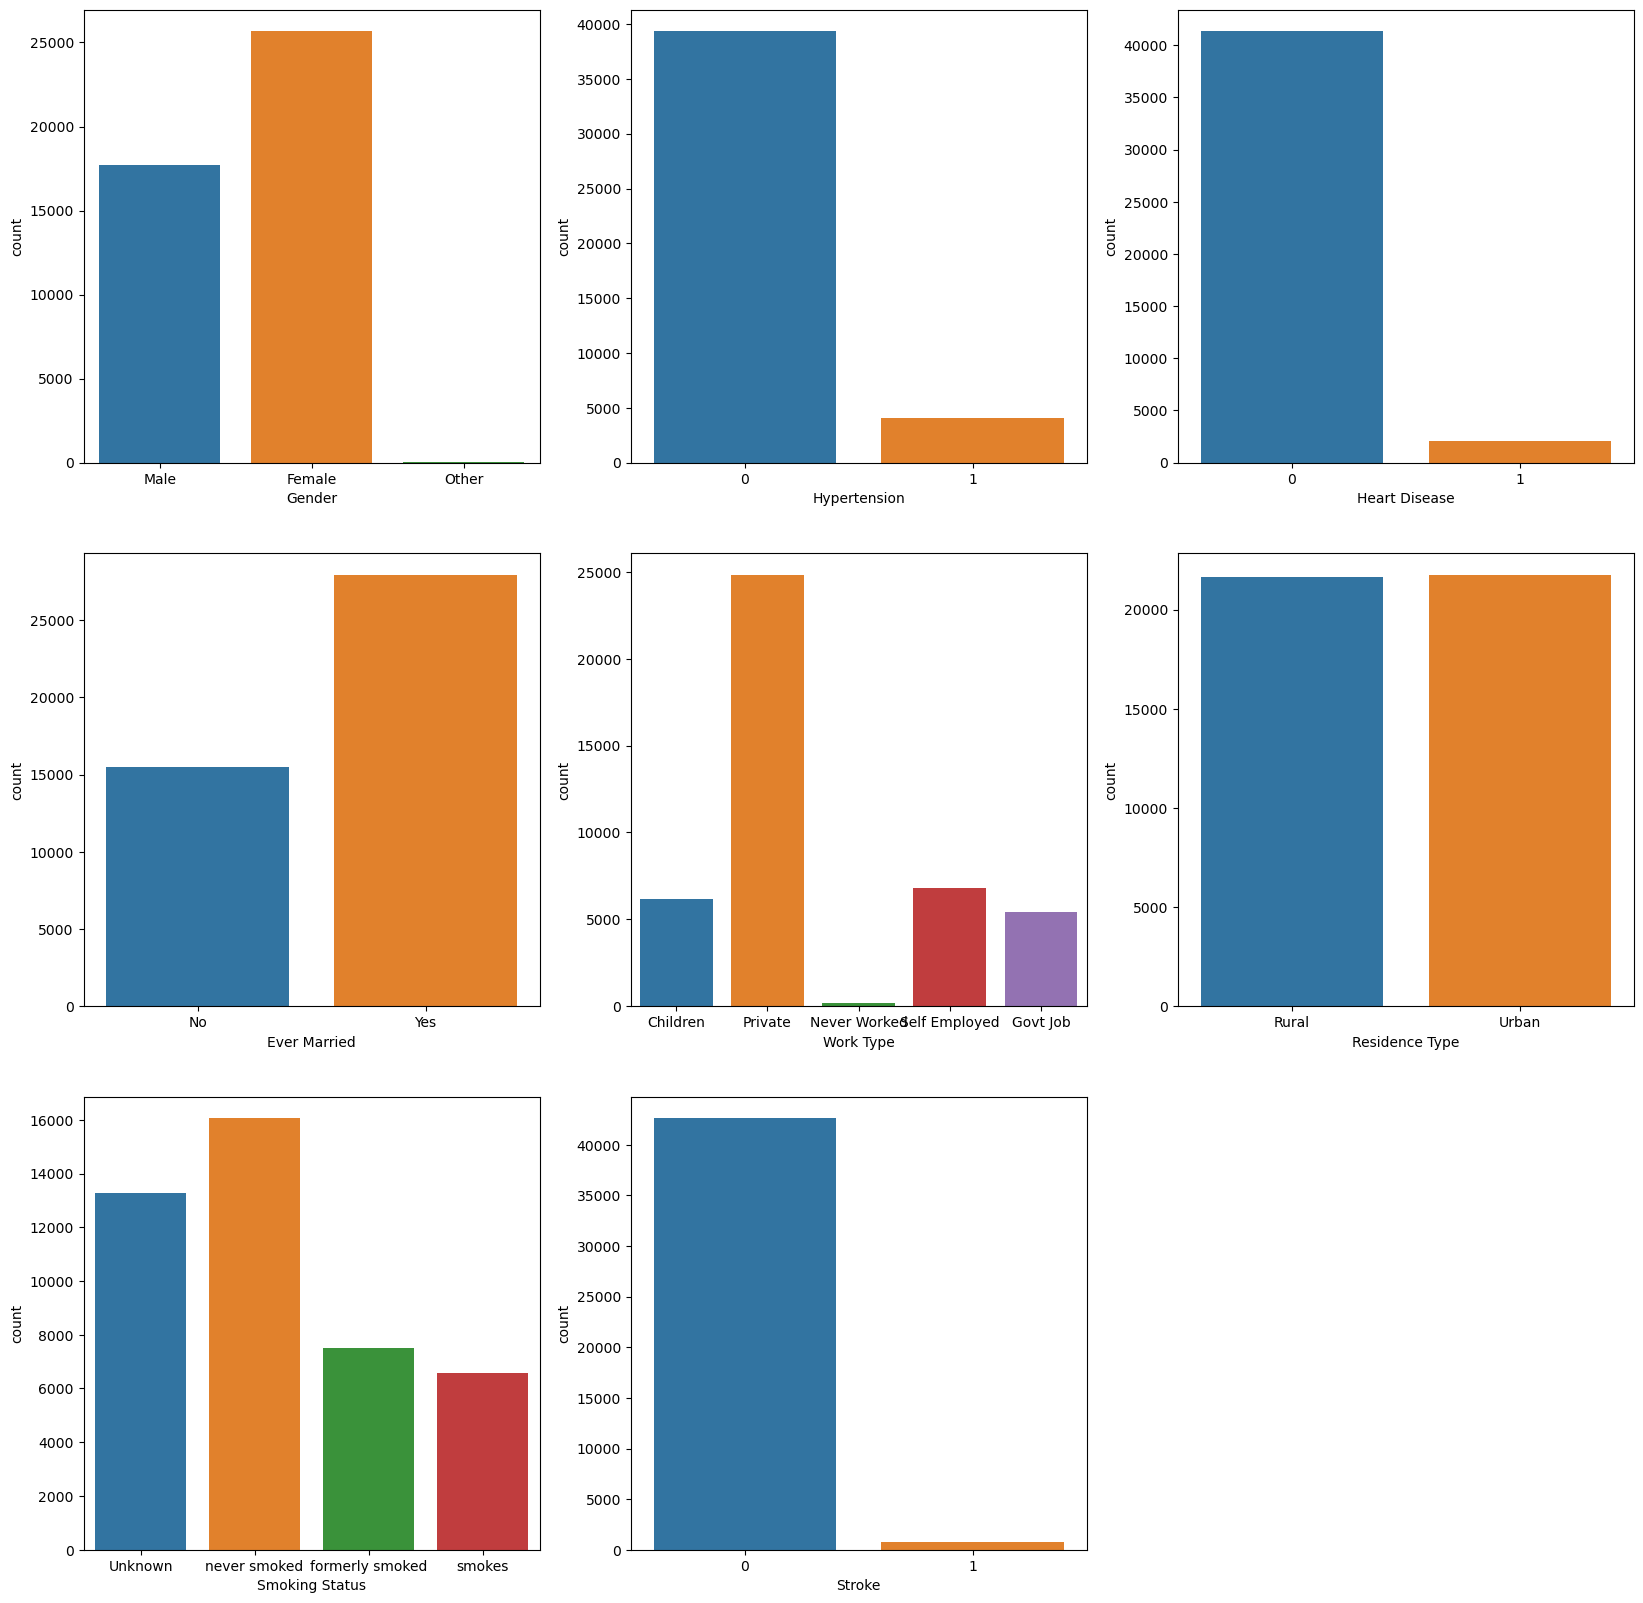

In [21]:
# Analysing categorical column

plt.figure(figsize=(20,20))
counts = 1

for i in cat:
    if counts<=len(cat):
        plt.subplot(3,3,counts)
        sns.countplot(df,x=i)
        plt.xlabel(i)
    counts+=1
plt.show() 
        
        

\
- Gender: There are 25,665 females, 17,724 males, and 11 individuals with other genders.
- Hypertension: 40,639 individuals do not have hypertension, while 4,061 individuals have hypertension.
- Heart Disease: 41,338 individuals do not have heart disease, and 2,062 individuals have heart disease.
- Ever Married: 27,938 individuals have been married, while 15,462 individuals have never been married.
- Work Type: The dataset includes individuals with various work types: 24,834 in private jobs, 6,793 in self-employed positions, 6,156 children, 5,440 in government jobs, and 177 individuals who have never worked.
- Residence Type: There are 21,756 individuals living in urban areas and 21,644 individuals living in rural areas.
- Smoking Status: 16,053 individuals never smoked, 13,292 have an unknown smoking status, 7,493 were formerly smokers, and 6,562 are current smokers.
- Stroke: There are 42,617 individuals without a history of stroke, and 783 individuals with a history of stroke. The dataset for stroke is imbalanced, with a significant difference between the occurrences of stroke and non-stroke instances. Handling this imbalance is crucial for accurate analysis and modeling.

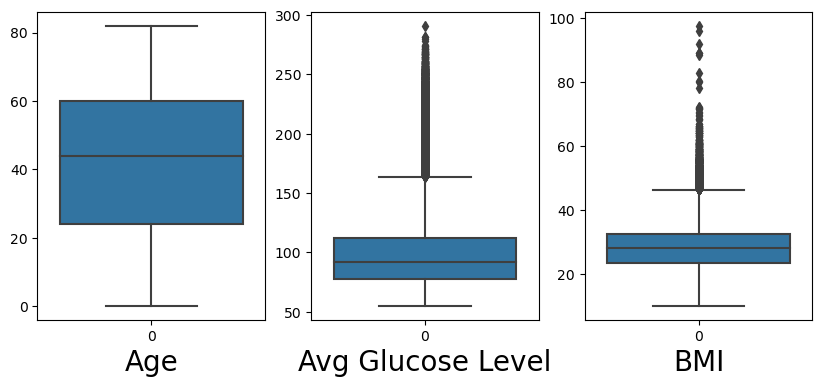

In [22]:
# checking outliers 

plt.figure(figsize=(10,4))
count = 1

for i in con:
    if count<=3:
        ax = plt.subplot(1,3,count)
        sns.boxplot(df[i])
        plt.xlabel(i, fontsize=20)
    count+=1
plt.show() 

- We can clearly see outliers in " Avg Glucose Level " and " BMI " so let's deal with them.

In [23]:
# converting object data into numerical

le = LabelEncoder()
for i in df.columns:
    if df[i].dtype == "object":
        df[i] = le.fit_transform(df[i])

In [24]:
# dealing with skweness using yoe-

columns_to_transform = ["Avg Glucose Level", "BMI"]
pt = PowerTransformer(method='yeo-johnson')

df[columns_to_transform] = pt.fit_transform(df[columns_to_transform])

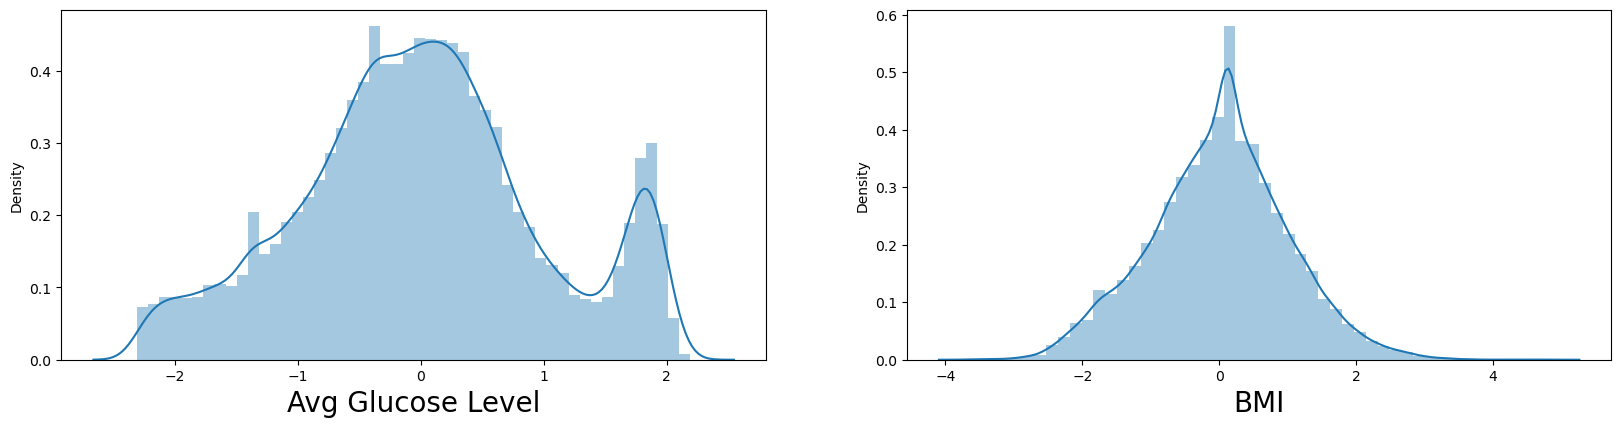

In [25]:
# checking skewness again

plt.figure(figsize=(20, 10))
con = ["Avg Glucose Level", "BMI"]

for count, i in enumerate(con, 1):
    plt.subplot(2, 2, count)
    sns.distplot(df[i])
    plt.xlabel(i, fontsize=20)

plt.show()


- We can see skewness is removed 
- We can use methods such as z-score and quantile range to eliminate outliers, but it is essential to retain genuine data points during the process.

### Dealing with imbalance data

In [26]:
# using SMOTE to deal with imbalance data

X = df.drop('Stroke', axis=1)
y = df['Stroke']

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

df = pd.concat([pd.DataFrame(X_smote, columns=X.columns), pd.Series(y_smote, name='Stroke')], axis=1)


In [27]:
# checking Stroke now

df.Stroke.value_counts()

0    42617
1    42617
Name: Stroke, dtype: int64

- Now that the data is no longer imbalanced, we can proceed with our analysis.

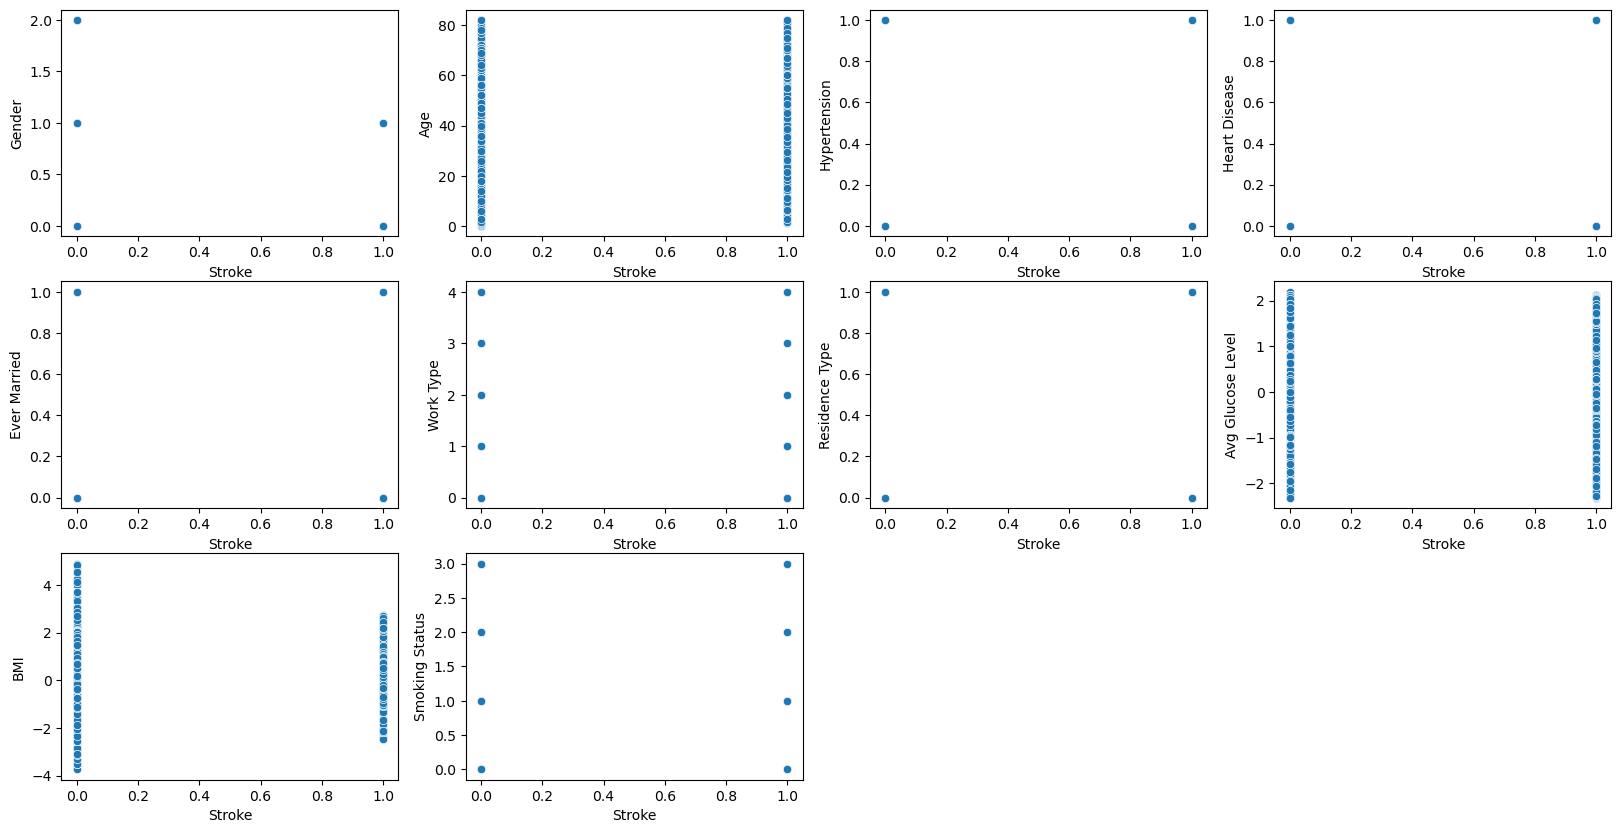

In [28]:
# Checking relation of each feature with label

plt.figure(figsize=(20,10))
c = 1
for i in X:
    if c<=10:
        ax = plt.subplot(3,4,c)
        sns.scatterplot(df,x='Stroke',y=i)
        plt.xlabel('Stroke')
        plt.ylabel(i)
    c+=1
plt.show()    

- Let's explore alternative methods to identify the relationship between the label and the features due to the lack of a clear pattern.

In [33]:
# scaling the data for analysis

x = df.drop(columns=['Stroke'], axis=1)
y = df['Stroke']
std = StandardScaler()
x_scaled = std.fit_transform(x)

In [34]:
# going with VIF to check multicollinearity and also for feature selection


vif_data_scaled = pd.DataFrame()
vif_data_scaled["Variable"] = x.columns
vif_data_scaled["VIF"] = [variance_inflation_factor(x, i) for i in range(x_scaled.shape[1])]

vif_data_scaled

,Variable,VIF
0,Gender,1.458588
1,Age,11.631484
2,Hypertension,1.165297
3,Heart Disease,1.150147
4,Ever Married,6.078531
5,Work Type,8.924245
6,Residence Type,1.638169
7,Avg Glucose Level,1.138214
8,BMI,1.106006
9,Smoking Status,2.796681


- 'Age' displays a high VIF (11.63), indicating potential multicollinearity with other variables.
- 'Work Type' and 'Ever Married' also show high VIF values (8.92 and 6.08, respectively), suggesting possible multicollinearity issues.
- 'Gender', 'Hypertension', 'Heart Disease', 'Residence Type', 'Avg Glucose Level', 'BMI', and 'Smoking Status' have VIF values close to 1, indicating minimal collinearity with other predictors.

Based on this analysis, 'Age', 'Work Type', and 'Ever Married' merit further investigation for potential multicollinearity concerns, while the other variables seem relatively independent.

<Axes: >

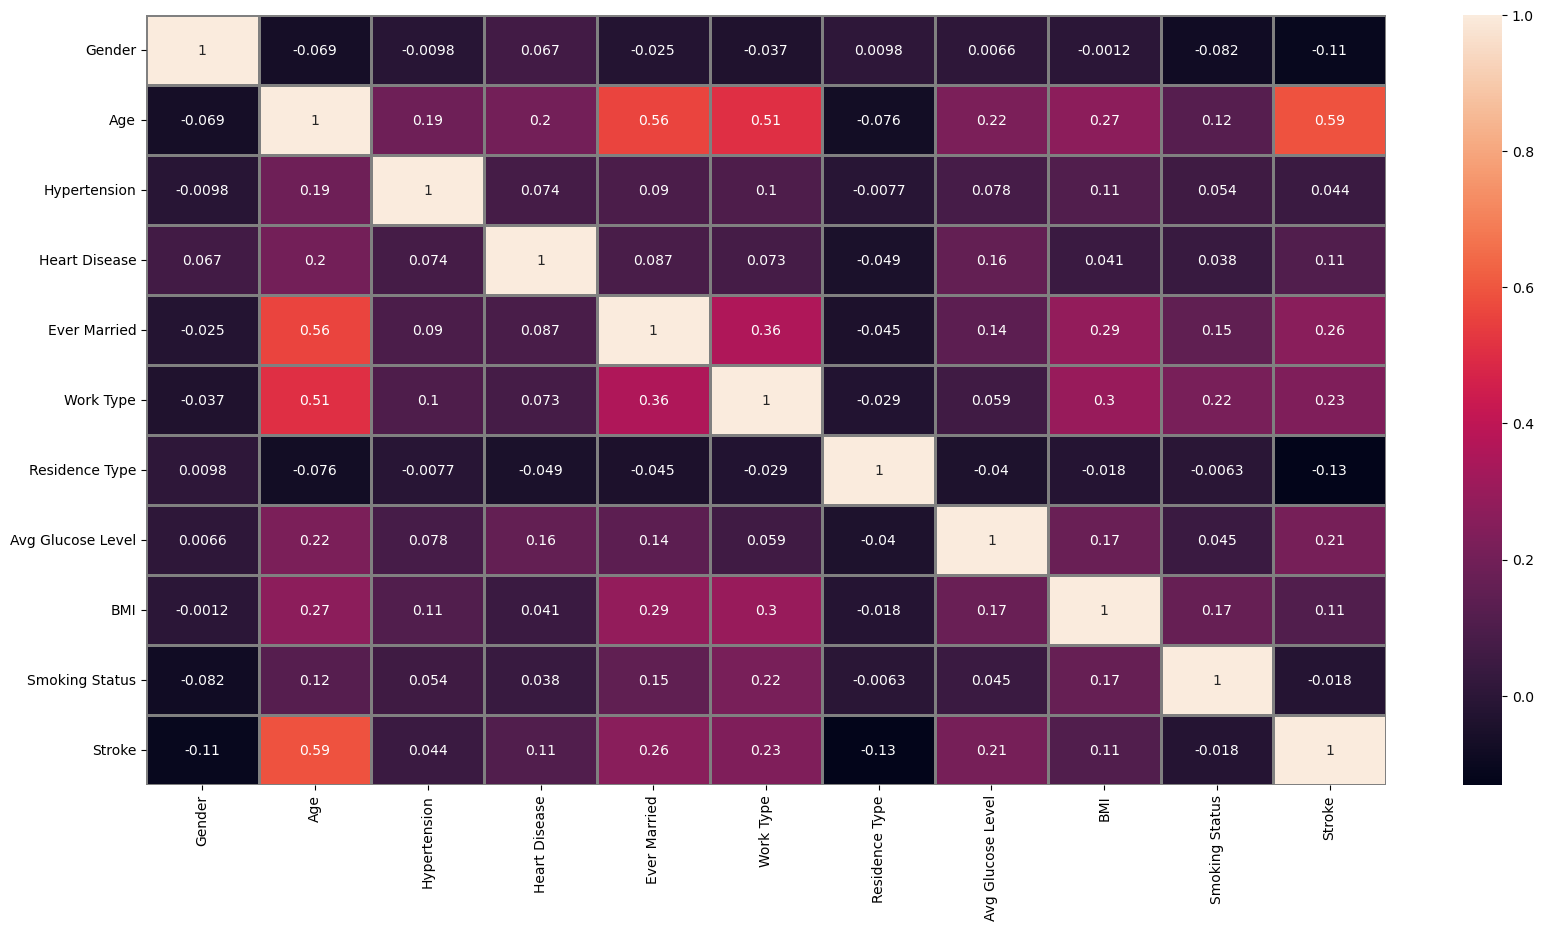

In [36]:
# using heatmap to check correlation and multicollinearity

plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,linecolor='grey',linewidths=2)

Multicollinearity Insights:
- 'Age' moderately correlates with 'Ever Married' and 'Work Type'.
- 'BMI' moderately correlates with 'Work Type' and 'Ever Married'.
- 'Ever Married' and 'Work Type' moderately correlate with each other.

Feature Selection Insights:
- 'Age' shows the strongest correlation with the 'Stroke' label.
- 'Ever Married' and 'Work Type' also display moderate correlations with the 'Stroke' label.
- 'Residence Type' and 'Smoking Status' exhibit the weakest correlations with the 'Stroke' label.

- so we can Choose 'Age', 'Ever Married', and 'Work Type' for predicting the 'Stroke' label. But we can further go we PCA to check it

In [37]:
# using pca for component reduction

from sklearn.decomposition import PCA

pca = PCA()
principal_components = pca.fit_transform(x_scaled)

explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio: ", explained_variance)

Explained Variance Ratio:  [0.24235188 0.11576484 0.10068143 0.09767546 0.09328207 0.09141106
 0.08903832 0.07179355 0.06219911 0.03580227]


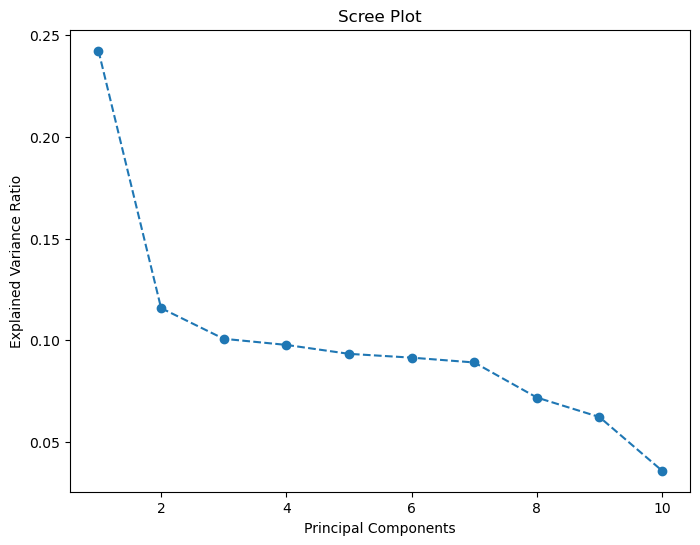

In [38]:
# scree plot for checking variance with components

plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

- Insights from PCA Explained Variance Ratio: The initial components contribute significantly to the variance, with diminishing contributions from subsequent components, indicating the potential for effective dimensionality reduction while preserving key information.

In [39]:
# checking those columns which are able to expain 70% of data

cumulative_variance = np.cumsum(explained_variance)

num_components = 8

selected_features = x.columns[:num_components]

print("Selected Features:")
print(selected_features)

Selected Features:
Index(['Gender', 'Age', 'Hypertension', 'Heart Disease', 'Ever Married',
       'Work Type', 'Residence Type', 'Avg Glucose Level'],
      dtype='object')


- After analysis, it is evident that 'Age', 'Heart Disease', 'Residence Type', 'Average Glucose Level', 'BMI', and 'Smoking Status' are suitable features for predicting the label. Utilizing these features helps eliminate multicollinearity issues and retains more than 70% of the variance.

### Model building

In [47]:
df.columns

Index(['Gender', 'Age', 'Hypertension', 'Heart Disease', 'Ever Married',
       'Work Type', 'Residence Type', 'Avg Glucose Level', 'BMI',
       'Smoking Status', 'Stroke'],
      dtype='object')

In [48]:
# seperating label and features
X = df[['Gender', 'Age', 'Heart Disease','Residence Type', 'Avg Glucose Level', 'BMI','Smoking Status']]
Y = df['Stroke']

In [49]:
X = std.fit_transform(X)

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=66, test_size=.3)
print('Training feature matrix size:',X_train.shape)
print('Training target vector size:',Y_train.shape)
print('Test feature matrix size:',X_test.shape)
print('Test target vector size:',Y_test.shape)

Training feature matrix size: (59663, 7)
Training target vector size: (59663,)
Test feature matrix size: (25571, 7)
Test target vector size: (25571,)


## Logistic regression 

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=99, test_size=.3)
log_reg=LogisticRegression()
log_reg.fit(X_train,Y_train)
y_pred=log_reg.predict(X_test)
print('\033[1m'+'Logistics Regression Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Logistics Regression :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Precision Score of Logistics Regression :'+'\033[0m', precision_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Logistics Regression :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Logistics Regression'+'\033[0m \n',classification_report(Y_test, y_pred))


from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(log_reg, X, Y, cv =5, scoring='precision')
print('\033[1m'+'Cross Validation Score', log_reg, ':'+'\033[0m\n')
print("Precision CVScore :" ,CVscore)
print("Mean CV Precision Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Logistics Regression Evaluation


Accuracy Score of Logistics Regression : 0.7718900316765085


Precision Score of Logistics Regression : 0.7533318767751802


Confusion matrix of Logistics Regression : 
 [[ 9394  3387]
 [ 2446 10344]]


classification Report of Logistics Regression 
               precision    recall  f1-score   support

           0       0.79      0.73      0.76     12781
           1       0.75      0.81      0.78     12790

    accuracy                           0.77     25571
   macro avg       0.77      0.77      0.77     25571
weighted avg       0.77      0.77      0.77     25571

Cross Validation Score LogisticRegression() :

Precision CVScore : [0.75523013 0.75385611 0.76019846 0.75297683 0.75905064]
Mean CV Precision Score : 0.7562624334142554
Std deviation : 0.002860684544857641



- The logistic regression model demonstrates a commendable accuracy of 0.772 and a precision of 0.753.
- The confusion matrix depicts a well-balanced classification output, with a minor bias towards positive instances.
- Cross-validation precision scores confirm the model's consistent performance, with a mean of 0.756 and a standard deviation of 0.003.

## Random Forest 

In [55]:
rfc=RandomForestClassifier()
rfc.fit(X_train,Y_train)
y_pred=rfc.predict(X_test)
print('\033[1m'+'Random Forest Classifier'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Random Forest Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Precision Score of Random Forest Classifier :'+'\033[0m', precision_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Random Forest Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Random Forest Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))


from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(rfc, X, Y, cv =5, scoring='precision')
print('\033[1m'+'Cross Validation Score', rfc, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Precision Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Random Forest Classifier


Accuracy Score of Random Forest Classifier : 0.9509991787571859


Precision Score of Random Forest Classifier : 0.931354221191954


Confusion matrix of Random Forest Classifier : 
 [[11863   918]
 [  335 12455]]


classification Report of Random Forest Classifier 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     12781
           1       0.93      0.97      0.95     12790

    accuracy                           0.95     25571
   macro avg       0.95      0.95      0.95     25571
weighted avg       0.95      0.95      0.95     25571

Cross Validation Score RandomForestClassifier() :

CVScore : [0.93854238 0.93434174 0.94142165 0.93368315 0.93849429]
Mean CV Precision Score : 0.9372966415950653
Std deviation : 0.0028910444141377277


- Achieves high accuracy (0.951) and precision (0.931) with robust performance across metrics.
- Displays balanced precision and recall, ensuring effective identification of both positive and negative instances.
- Cross-validation results show consistent precision scores (mean: 0.937, std: 0.003), indicating stable and reliable performance.

##  AdaBoost Classifier

In [56]:
adbc=AdaBoostClassifier()
adbc.fit(X_train,Y_train)
y_pred=adbc.predict(X_test)
print('\033[1m'+'AdaBoost Classifier Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of AdaBoost Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Precision Score of Extra Trees Classifier :'+'\033[0m', precision_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of AdaBoost Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of AdaBoost Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))



from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(adbc, X, Y, cv =5, scoring='precision')
print('\033[1m'+'Cross Validation Score',adbc, ':'+'\033[0m\n')
print("Precision CVScore :" ,CVscore)
print("Mean Precision CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

AdaBoost Classifier Evaluation


Accuracy Score of AdaBoost Classifier : 0.7910523640061007


Precision Score of Extra Trees Classifier : 0.7685151799235596


Confusion matrix of AdaBoost Classifier : 
 [[ 9571  3210]
 [ 2133 10657]]


classification Report of AdaBoost Classifier 
               precision    recall  f1-score   support

           0       0.82      0.75      0.78     12781
           1       0.77      0.83      0.80     12790

    accuracy                           0.79     25571
   macro avg       0.79      0.79      0.79     25571
weighted avg       0.79      0.79      0.79     25571

Cross Validation Score AdaBoostClassifier() :

Precision CVScore : [0.7637931  0.76808647 0.77969056 0.7680596  0.77837131]
Mean Precision CV Score : 0.7716002104670687
Std deviation : 0.0062790881269742405




- The AdaBoost Classifier demonstrates a good accuracy of 0.791 and precision of 0.769, indicating a reliable overall predictive performance.
- The confusion matrix illustrates a balanced classification output, with 9571 true negatives, 3210 false positives, 2133 false negatives, and 10657 true positives.
- The classification report displays reasonably balanced precision and recall for both classes, ensuring effective identification of both positive and negative instances.
- Cross-validation results show consistent precision scores, with a mean of 0.772 and a standard deviation of 0.006, reflecting stable performance across multiple folds.

__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__

Upon reviewing the performance of the three models, the **Random Forest Classifier exhibits the most robust predictive capabilities, with an accuracy of 0.951 and a precision of 0.931. It effectively handles complex data relationships and displays a lower standard deviation in cross-validation precision scores, indicating stable and reliable performance. Hence, it appears to be the most promising candidate for further hyperparameter tuning.** While the AdaBoost Classifier and Logistic Regression showcase respectable performances, the Random Forest Classifier surpasses them in various critical metrics, underscoring its potential to deliver superior predictive results.

In [64]:
# hyper parameter Tuning for increasing model performance

rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [5, 10, 15],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [65]:
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}
Best Score:  0.9411695802176746


In [72]:
# Initialize the Random Forest Classifier with the best parameters
best_rfc = RandomForestClassifier(n_estimators=250, max_depth=None, min_samples_split=2, min_samples_leaf=1)

# Fit the classifier on the training data
best_rfc.fit(X_train, Y_train)

# Make predictions on the test data
y_pred_best = best_rfc.predict(X_test)

# Print the evaluation metrics
print('\033[1m' + 'Random Forest Classifier' + '\033[0m')
print('\n')
print('\033[1m' + 'Accuracy Score of Random Forest Classifier :' + '\033[0m', accuracy_score(Y_test, y_pred_best))
print('\n')
print('\033[1m' + 'Precision Score of Random Forest Classifier :' + '\033[0m', precision_score(Y_test, y_pred_best))
print('\n')
print('\033[1m' + 'Confusion matrix of Random Forest Classifier :' + '\033[0m \n', confusion_matrix(Y_test, y_pred_best))
print('\n')
print('\033[1m' + 'classification Report of Random Forest Classifier' + '\033[0m \n', classification_report(Y_test, y_pred_best))


Random Forest Classifier


Accuracy Score of Random Forest Classifier : 0.9526807711861093


Precision Score of Random Forest Classifier : 0.9333183655141446


Confusion matrix of Random Forest Classifier : 
 [[11890   891]
 [  319 12471]]


classification Report of Random Forest Classifier 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     12781
           1       0.93      0.98      0.95     12790

    accuracy                           0.95     25571
   macro avg       0.95      0.95      0.95     25571
weighted avg       0.95      0.95      0.95     25571



- Upon implementing hyperparameter tuning, the Random Forest Classifier demonstrates enhanced performance, with an increased accuracy of 0.953 and precision of 0.933. The confusion matrix reveals a notable improvement, with 11890 true negatives, 891 false positives, 319 false negatives, and 12471 true positives. The classification report demonstrates a consistent enhancement in precision and recall for both classes, highlighting the model's improved ability to correctly identify positive and negative instances. The refined results underscore the effectiveness of the hyperparameter tuning process in optimizing the Random Forest Classifier's predictive capabilities.

In [74]:
# saving the final model 


filename = 'Cerebral_Stroke_Prediction_Classifier.pkl'
pickle.dump(best_rfc, open(filename, 'wb'))

In [75]:
# loading the model

loaded_model = pickle.load(open(filename, 'rb'))

In [80]:
# Perdicting random values


random_indices = random.sample(range(len(X)), 5)

# Predicting the target values for the selected indices
for index in random_indices:
    data_instance = X[index].reshape(1, -1)
    prediction = loaded_model.predict(data_instance)
    print(f"Prediction for data instance at index {index}: {prediction}")


Prediction for data instance at index 66736: [1]
Prediction for data instance at index 67755: [1]
Prediction for data instance at index 75189: [1]
Prediction for data instance at index 17462: [0]
Prediction for data instance at index 55988: [1]
